In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split

In [72]:
df7=pd.read_csv('data.csv')
df7

,Unnamed: 0,lat,lon,QC_Flag,year,day,month,hour,minute,second,pCO2_SST,fCO2_SST
0,138352,14.982,89.929,C,2016,6,3,6,17,0.0,373.5,372.30
1,138353,14.982,89.929,C,2016,6,3,6,47,0.0,376.0,374.80
2,138354,14.982,89.929,C,2016,6,3,7,17,0.0,376.7,375.50
3,138355,14.982,89.929,C,2016,6,3,7,47,0.0,376.3,375.10
4,138356,14.982,89.929,C,2016,6,3,8,17,0.0,374.8,373.70
...,...,...,...,...,...,...,...,...,...,...,...,...
25583,380070,5.260,90.170,D,1987,3,7,1,59,0.0,NaN,366.04
25584,380071,5.340,90.540,D,1987,3,7,4,0,0.0,NaN,382.71
25585,380072,5.390,90.810,D,1987,3,7,4,59,0.0,NaN,350.38
25586,380073,5.450,91.100,D,1987,3,7,6,0,0.0,NaN,352.08


In [73]:
df7=df7.drop('Unnamed: 0', axis=1)

In [74]:
nan_rows = df7[df7[['pCO2_SST', 'fCO2_SST']].isna().any(axis=1)]

In [75]:
# Calculate 100% of the NaN rows
num_nan_to_select = int(1.0 * len(nan_rows))

In [76]:
# Randomly select 100% of NaN rows
nan_sample = nan_rows.sample(n=num_nan_to_select, random_state=42)

In [77]:
# Get rows that are fully non-NaN in 'pCO2_SST' and 'fCO2_SST'
non_nan_rows = df7.dropna(subset=['pCO2_SST', 'fCO2_SST'])

In [78]:
# Combine 100% NaN rows with all non-NaN rows
new_df = pd.concat([nan_sample, non_nan_rows])

In [79]:
new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [80]:
x=new_df.drop('pCO2_SST', axis=1)
y=new_df['pCO2_SST']

In [81]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
x['QC_Flag']=encoder.fit_transform(x['QC_Flag'])

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [83]:
median_pCO2=y_train.median(skipna=True)
y_train=y_train.fillna(median_pCO2)
y_test=y_test.fillna(median_pCO2)

In [84]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
xgb_model=XGBRegressor(n_estimators=600, max_depth=4, learning_rate=0.02, eval_metric='rmse', random_state=42)
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [85]:
y_train_pred=xgb_model.predict(x_train)
y_test_pred=xgb_model.predict(x_test)

training_accuracy=np.sqrt(mean_squared_error(y_train, y_train_pred))
testing_accuracy=np.sqrt(mean_squared_error(y_test, y_test_pred))

print('XGBoost Regression :')
print('Training Error :',training_accuracy)
print('Testing Error :',testing_accuracy)

XGBoost Regression :
Training Error : 0.36392086221783265
Testing Error : 0.3670602888088299


<Figure size 1400x600 with 0 Axes>

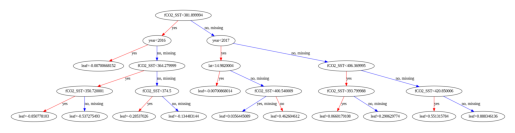

In [86]:
from xgboost import plot_tree
plt.figure(figsize=(14, 6))
plot_tree(xgb_model, num_trees=0)  # Plot the first tree
plt.show()

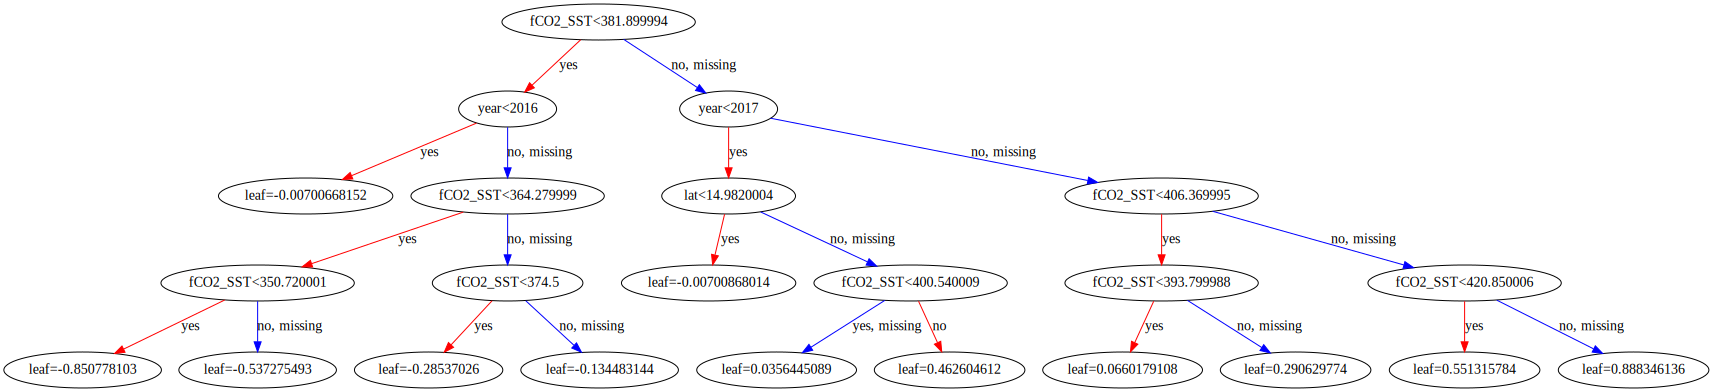

In [67]:
dot_data = xgb.to_graphviz(xgb_model, num_trees=0)
dot_data.render("xgboost_tree")
dot_data

<Figure size 1200x600 with 0 Axes>

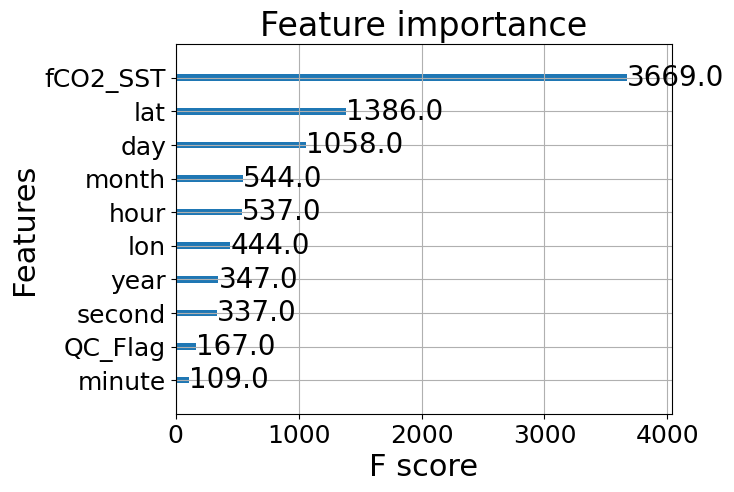

In [87]:
import xgboost as xgb
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model)
plt.show()